In [1]:
# Imports
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow.keras import mixed_precision
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten
from sklearn import metrics, ensemble
from tensorflow.config import experimental

In [2]:
# Using either TPU or GPU to speed up model fitting
# Use mixed precision policy if TPU/GPUs are detected for additional performance boost
# see https://www.tensorflow.org/guide/mixed_precision
if experimental.list_physical_devices("TPU"):  # Googles Tensor Processing Units
    print("Available TPUs: ", len(experimental.list_physical_devices("TPU")))
    mixed_precision.set_global_policy(mixed_precision.Policy("mixed_bfloat16"))
elif experimental.list_physical_devices("GPU"):  # NVidia GPU
    print("Available GPUs: ", len(experimental.list_physical_devices("GPU")))
    print("Selecting the first GPU...")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # use the first GPU
    mixed_precision.set_global_policy(mixed_precision.Policy("mixed_float16"))
else:
    print("No TPUs or GPUs detected.")
# Note: if mixed precision float16 is used, your output layer should be transferred to
# float32 because float16 are not always numerically stable.

Available GPUs:  1
Selecting the first GPU...
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Ti, compute capability 8.6


X_train is of shape:  (60000, 28, 28)
Unique target labels in y_train and y_test:  [0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]


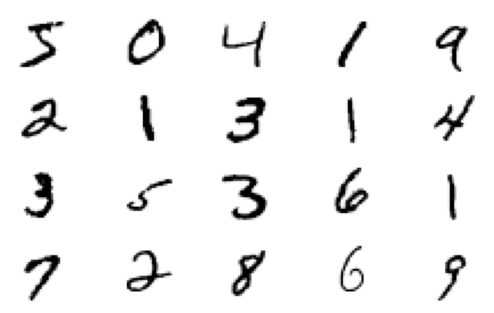

In [3]:
# Load in MNIST data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Make sure to always clear session at the beginning to not just update previous model instances
# Note that this is mostly important for Jupyter Notebooks but good practice either way
K.clear_session()

# Inspect the shape and classes
print("X_train is of shape: ", X_train.shape)
print("Unique target labels in y_train and y_test: ", np.unique(y_train), np.unique(y_test))
# We got 60000 images of 10 different digits of 28x28 pixel size and one color channel (black/white)

# Plot the first 20 digits
for image_idx in range(20):
    plt.subplot(5, 5, image_idx + 1)
    plt.imshow(X_train[image_idx], cmap=plt.cm.Greys)
    plt.axis("off")
plt.show()

Now that we know the data set, let's start building the model
We will build two different models

1. Model 1 is a regular ANN of the feed-forward type
2. Model 2 is a CNN of the feed-forward type
3. Model 3 is a regular RandomForestClassifier as a baseline model

### Model 1: Regular ANN of the feed-forward type

In [4]:
# Prepare the data set for modelling
# Split the reshaped data set
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
# Rescale pixel intensities from a 0-255 to a 0-1 range (i.e., MinMaxScaling)
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# One-hot encode the target classes / labels (i.e., 10 digits)
# Needed so that the dimensions match the Dense output layer (at least with softmax activation function)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### Define our model:
We know that the input are 28 x 28 x 1 images.  
We have 10 different digits, so the output layer must have 10 nodes.  
Relu is a popular activation function for hidden layers.  
Softmax is a popular activation function for the last, or output, layer.  

#### Pipeline the model
From Keras model training API (https://keras.io/api/models/model_training_apis/).  
- Dense: Regular densely-connected neural network layer  
units: neurons/nodes for that layer  
activation: activation function for the nodes  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
name: some label you can give that layer  
Note that we do not need to add a bias for each layer as they are automatically added in Keras for Dense layers  
- BatchNormalization: Layer that normalizes the input  
- Dropout: Randomly sets input units to 0 with rate frequency during training. Helps to prevent overfitting.  

In [5]:
model1 = Sequential(
    [
        Dense(units=200, activation="relu", input_shape=((784,)), name="HiddenLayer1"),
        BatchNormalization(),
        Dropout(rate=0.5),
        Dense(units=50, activation="relu", name="HiddenLayer2"),
        BatchNormalization(),
        Dropout(rate=0.5),
        Dense(units=10, activation="softmax", name="OutputLayer"),
    ]
)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer1 (Dense)        (None, 200)               157000    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 HiddenLayer2 (Dense)        (None, 50)                10050     
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 50)                0

#### Compile the model
loss: loss function to return error estimation  
optimizer: algorithm for loss minimization  
metrics: model performance evaluation metric  


In [6]:
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit the model
batch_size: number of samples per gradient update  
epochs: number of iterations over the entire data (X and y) to train the model  
validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch (no training on this data!)  


In [7]:
model1_history = model1.fit(
    x=X_train, y=y_train, batch_size=500, epochs=35, validation_data=(X_test, y_test)
)

Epoch 1/35
120/120 [==============================] - 2s 9ms/step - loss: 0.8645 - accuracy: 0.7388 - val_loss: 0.5071 - val_accuracy: 0.9131
Epoch 2/35
120/120 [==============================] - 1s 8ms/step - loss: 0.3971 - accuracy: 0.8860 - val_loss: 0.2464 - val_accuracy: 0.9349
Epoch 3/35
120/120 [==============================] - 1s 8ms/step - loss: 0.3058 - accuracy: 0.9136 - val_loss: 0.1648 - val_accuracy: 0.9505
Epoch 4/35
120/120 [==============================] - 1s 8ms/step - loss: 0.2545 - accuracy: 0.9276 - val_loss: 0.1371 - val_accuracy: 0.9572
Epoch 5/35
120/120 [==============================] - 1s 8ms/step - loss: 0.2230 - accuracy: 0.9365 - val_loss: 0.1216 - val_accuracy: 0.9624
Epoch 6/35
120/120 [==============================] - 1s 10ms/step - loss: 0.1974 - accuracy: 0.9429 - val_loss: 0.1112 - val_accuracy: 0.9649
Epoch 7/35
120/120 [==============================] - 1s 11ms/step - loss: 0.1836 - accuracy: 0.9479 - val_loss: 0.1015 - val_accuracy: 0.9687
Epoc

#### Evaluate the model
Plot the training history


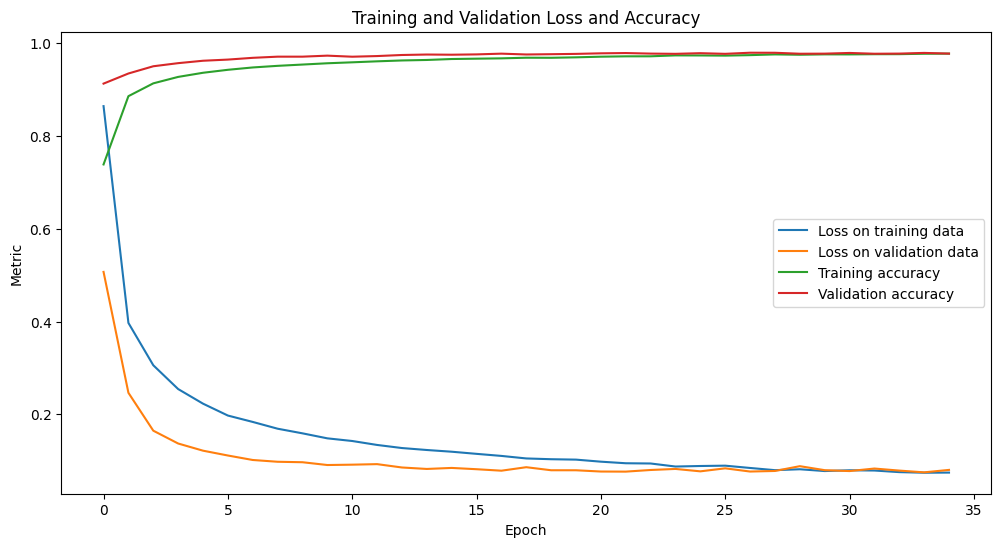

In [8]:
_fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(model1_history.history["loss"], label="Loss on training data")
ax.plot(model1_history.history["val_loss"], label="Loss on validation data")
ax.plot(model1_history.history["accuracy"], label="Training accuracy")
ax.plot(model1_history.history["val_accuracy"], label="Validation accuracy")
ax.set_title("Training and Validation Loss and Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Metric")
ax.legend()
plt.show()

In [9]:
# Return final model performance scores on training and test data
train_loss, train_acc = model1.evaluate(X_train, y_train)
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Train accuracy:", round(train_acc, 5))
print(
    "Train loss:",
    round(
        train_loss,
    ),
)
print("Test accuracy:", round(test_acc, 5))
print("Test loss:", round(test_loss, 3))


313/313 [==============================] - 1s 4ms/step - loss: 0.0802 - accuracy: 0.9778
Train accuracy: 0.99513
Train loss: 0
Test accuracy: 0.9778
Test loss: 0.08


Accuracy is already very good, so the model seems to be performing very well already.  
Let's plot a few digits together with their predictions

313/313 [==============================] - 1s 2ms/step


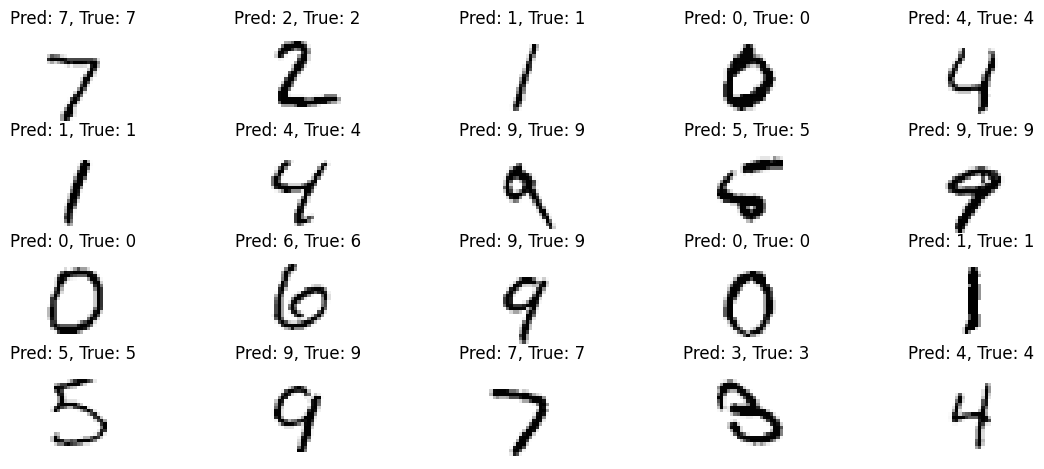

In [10]:
predictions = model1.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # get the predicted classes
y_actual = np.argmax(y_test, axis=1)  # get the actual classes

# Plot the first 20 digits with predicted and actual labels
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(y_pred[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_actual[idx]))
plt.show()

More informative are probably those digits that were not correctly predicted.  
Thus, plot the first 20 incorrectly predicted digits to understand why they were predicted incorrectly.


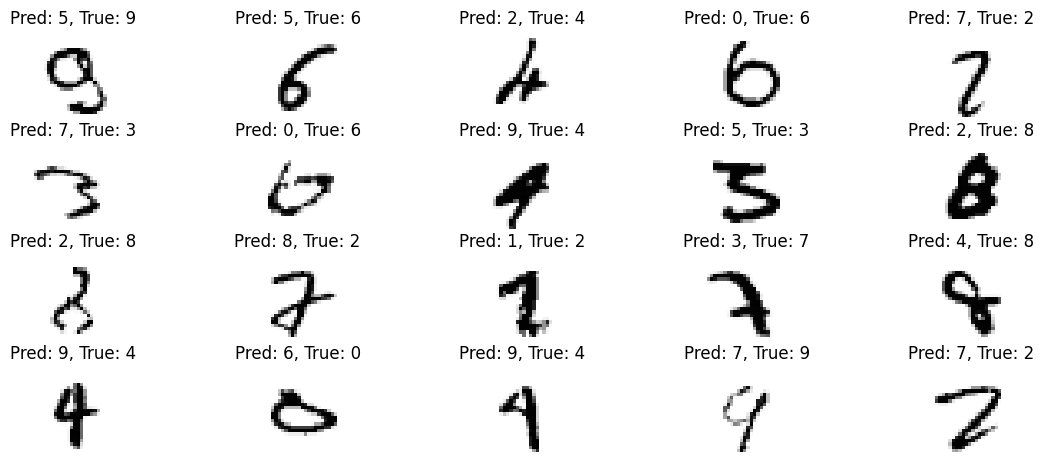

In [11]:
y_pred_incorrect = y_pred[y_pred != y_actual]
y_actual_incorrect = y_actual[y_pred != y_actual]
X_test_incorrect = X_test[y_pred != y_actual]
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(y_pred_incorrect[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test_incorrect[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_actual_incorrect[idx]))
plt.show()

Text(0.5, 36.72222222222221, 'Actual digit')

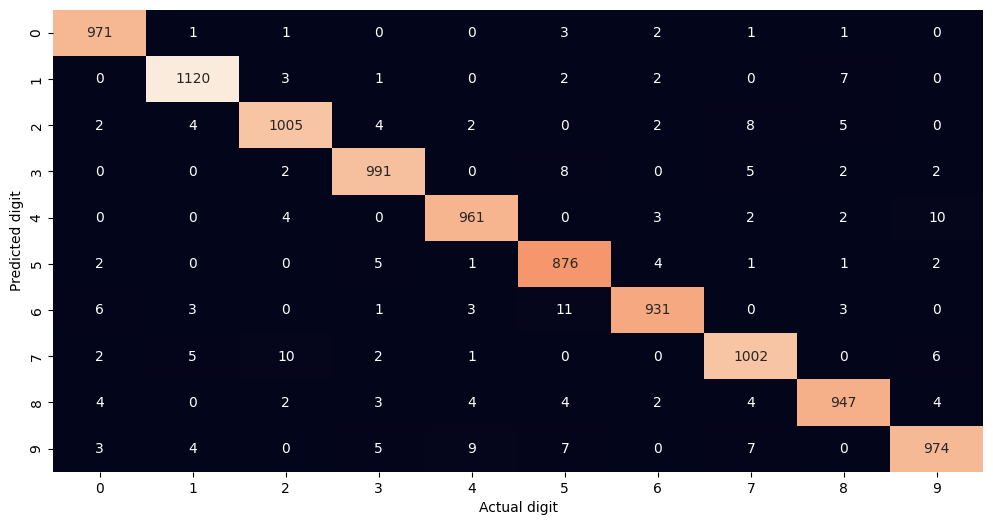

In [12]:
# Plot the confusion matrix of our predictions
_fig, ax2 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_actual, y_pred), cbar=False, annot=True, fmt="", ax=ax2)
ax2.set_ylabel("Predicted digit")
ax2.set_xlabel("Actual digit")

This shows that the incorrect predictions were not really random errors. Instead, the predictions were mostly due to digits that are fairly similar to begin with and that just happened to be written ambigously

### Model 2: a CNN of the feed-forward type

In [13]:
# Reload in MNIST data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Clear the Keras session
K.clear_session()

# Prepare the data set for modelling
# Split the reshaped data set
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))
# Rescale pixel intensities from a 0-255 to a 0-1 range (i.e., MinMaxScaling)
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# One-hot encode the target classes / labels
# Needed so that the dimensions match the Dense output layer (at least with softmax activation function)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#### Define our model
We know that the input are 28 x 28 x 1 images.  
We have 10 different digits, so the output layer must have 10 nodes.  
Relu is a popular activation function for hidden layers.  
Softmax is a popular activation function for the last, or output, layer.  
  
#### Pipeline the model
From Keras model training API (https://keras.io/api/models/model_training_apis/).  
- Dense: Regular densely-connected neural network layer  
units: neurons/nodes for that layer  
activation: activation function for the nodes  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
name: some label you can give that layer  
Note that we do not need to add a bias for each layer as they are automatically added in Keras for Dense layers.  
- Conv2D: A 2D convolutional layer which creates a kernel that is convolved with the layer input to produce a tensor of outputs  
filters: dimensionality of output space (i.e., number of output filters in convolution)  
padding: results in zeros evenly to left/right or up/down of the input  
activation: activation function for the nodes  
kernel_size: specifies height and width of 2D convolution window  
input_shape: dimensional shape of the input, only needs to be defined for the first layer  
- MaxPool2D: Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions (h x w) by taking max value over input window (pool_size) for each channel of the input (e.g. pixel)
- Flatten: Flattens the layer from an multidimensional matrix into a vector  
- Dropout: Randomly sets input units to 0 with rate frequency during training. Helps to prevent overfitting.  

In [14]:
model2 = Sequential()
model2.add(
    Conv2D(
        filters=32,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
        input_shape=(28, 28, 1),  # rows, cols, color channels
    )
)
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(
    Conv2D(
        filters=64,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
    )
)
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(
    Conv2D(
        filters=64,
        padding="same",
        activation="relu",
        kernel_size=(3, 3),
    )
)
model2.add(Flatten())
model2.add(Dense(64, activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(10, activation="softmax"))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 3136)              0

#### Compile the model
loss: loss function to return error estimation  
optimizer: algorithm for loss minimization  
metrics: model performance evaluation metric  

In [15]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#### Fit the model
batch_size: number of samples per gradient update  
epochs: number of iterations over the entire data (X and y) to train the model  
validation_split: fraction of training data used as validation: evaluates the loss and any model metrics at the end of each epoch (no training on this data!)  

In [16]:
model2_history = model2.fit(x=X_train, y=y_train, batch_size=500, epochs=10, validation_split=0.1)

Epoch 1/10
108/108 [==============================] - 3s 11ms/step - loss: 0.5608 - accuracy: 0.8253 - val_loss: 0.0976 - val_accuracy: 0.9725
Epoch 2/10
108/108 [==============================] - 1s 9ms/step - loss: 0.1383 - accuracy: 0.9603 - val_loss: 0.0623 - val_accuracy: 0.9817
Epoch 3/10
108/108 [==============================] - 1s 9ms/step - loss: 0.0973 - accuracy: 0.9717 - val_loss: 0.0517 - val_accuracy: 0.9855
Epoch 4/10
108/108 [==============================] - 1s 9ms/step - loss: 0.0741 - accuracy: 0.9783 - val_loss: 0.0410 - val_accuracy: 0.9887
Epoch 5/10
108/108 [==============================] - 1s 9ms/step - loss: 0.0575 - accuracy: 0.9832 - val_loss: 0.0342 - val_accuracy: 0.9898
Epoch 6/10
108/108 [==============================] - 2s 23ms/step - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.0373 - val_accuracy: 0.9892
Epoch 7/10
108/108 [==============================] - 1s 11ms/step - loss: 0.0439 - accuracy: 0.9870 - val_loss: 0.0344 - val_accuracy: 0.9902
Epo

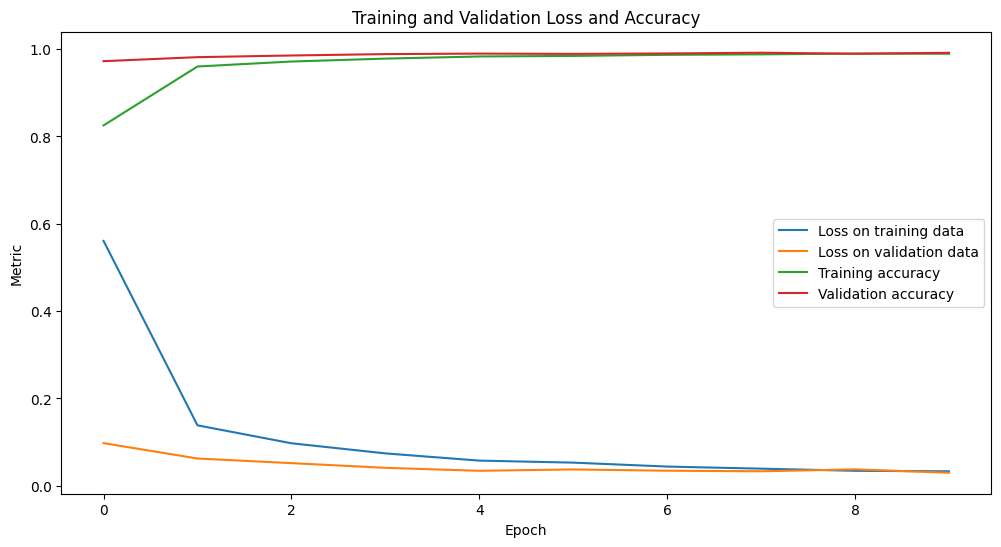

In [17]:
# Evaluate the model
# Plot the training history
_fig, ax3 = plt.subplots(figsize=(12, 6))
ax3.plot(model2_history.history["loss"], label="Loss on training data")
ax3.plot(model2_history.history["val_loss"], label="Loss on validation data")
ax3.plot(model2_history.history["accuracy"], label="Training accuracy")
ax3.plot(model2_history.history["val_accuracy"], label="Validation accuracy")
ax3.set_title("Training and Validation Loss and Accuracy")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Metric")
ax3.legend()
plt.show()

In [18]:
# Return final model performance scores on training and test data
train_loss, train_acc = model2.evaluate(X_train, y_train)
test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Train accuracy:", round(train_acc, 5))
print(
    "Train loss:",
    round(
        train_loss,
    ),
)
print("Test accuracy:", round(test_acc, 5))
print("Test loss:", round(test_loss, 3))


313/313 [==============================] - 1s 3ms/step - loss: 0.0233 - accuracy: 0.9928
Train accuracy: 0.99535
Train loss: 0
Test accuracy: 0.9928
Test loss: 0.023


Accuracy is slightly better than model 1!

313/313 [==============================] - 0s 1ms/step


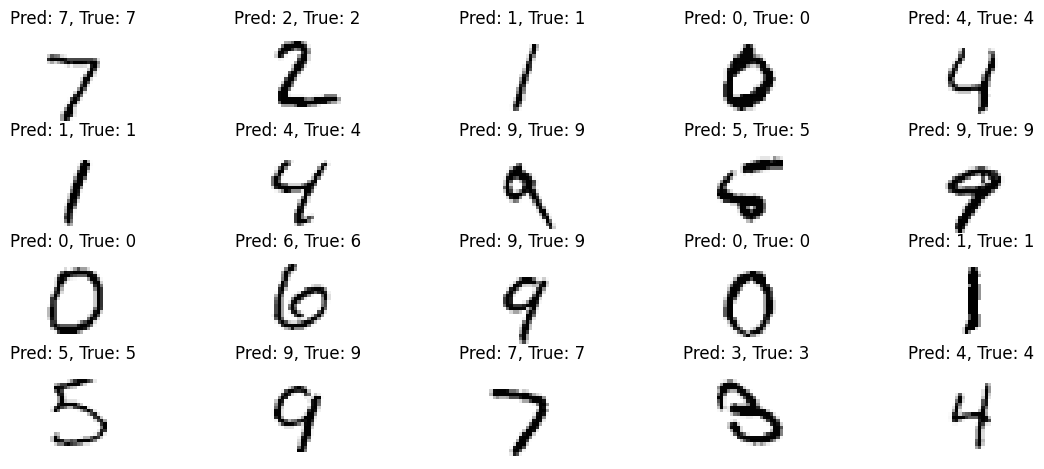

In [19]:
# Let's plot a few digits together with their predictions
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # get the predicted classes
y_actual = np.argmax(y_test, axis=1)  # get the actual classes

# Plot the first 20 digits with predicted and actual labels
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(y_pred[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_actual[idx]))
plt.show()

More informative are probably those digits that were not correctly predicted.  
Thus, plot the first 20 incorrectly predicted digits to understand why they were predicted incorrectly.

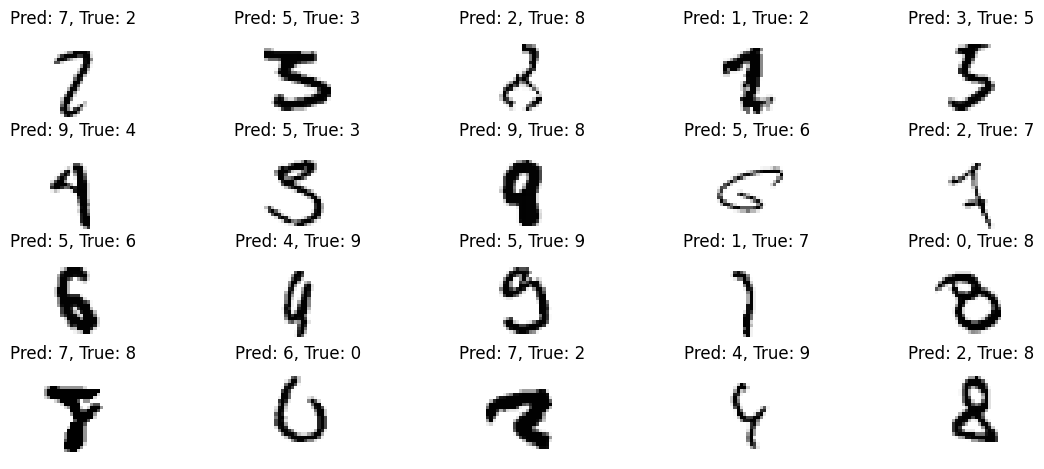

In [20]:
y_pred_incorrect = y_pred[y_pred != y_actual]
y_actual_incorrect = y_actual[y_pred != y_actual]
X_test_incorrect = X_test[y_pred != y_actual]
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(y_pred_incorrect[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test_incorrect[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_actual_incorrect[idx]))
plt.show()

Text(0.5, 36.72222222222221, 'Actual digit')

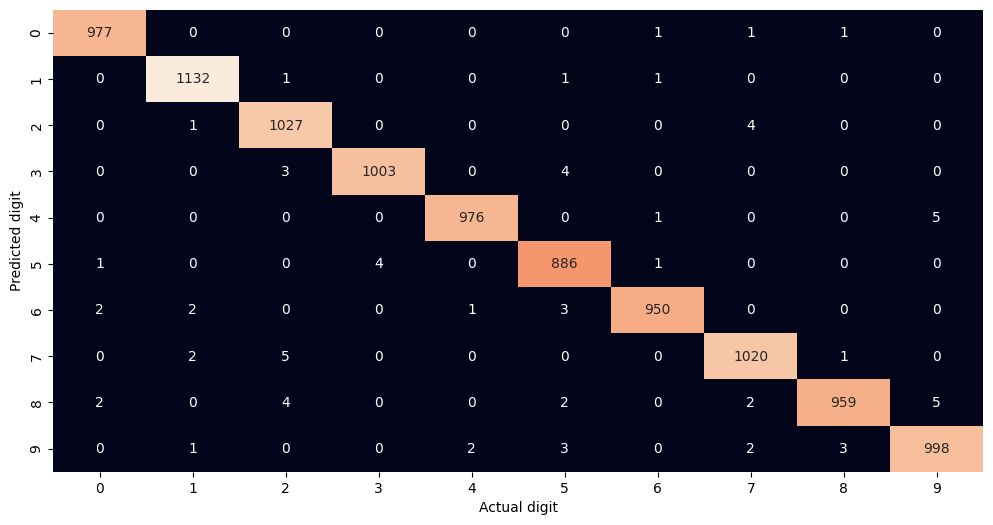

In [21]:
# Plot the confusion matrix of our predictions
_fig, ax4 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_actual, y_pred), cbar=False, annot=True, fmt="", ax=ax4)
ax4.set_ylabel("Predicted digit")
ax4.set_xlabel("Actual digit")

#### Save / Reload both models

In [22]:
model1.save("models/mnist/model1_ANN.h5")
model2.save("models/mnist/model2_CNN.h5")

# Reload with
# model2 = load_model("models/mnist/model2_CNN.h5")

### Model 3: a regular RandomForestClassifier as a baseline model

We could also do this directly in keras, see https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel  
...but will use sklearn here.

In [23]:
# Reload in MNIST data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Clear the Keras session
K.clear_session()

# Prepare the data set for modelling
# Split the reshaped data set (flattened entirely)
X_train = X_train.reshape((60000, -1))
X_test = X_test.reshape((10000, -1))
# Rescale pixel intensities from a 0-255 to a 0-1 range (i.e., MinMaxScaling)
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

#### Create and fit model

In [24]:
# Create a classifier: a RandomForestCLassifier
clf = ensemble.RandomForestClassifier(verbose=True)
# Fit
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   30.3s finished


RandomForestClassifier(verbose=True)

#### Evaluate the model

In [25]:
# Predict the value of the digit on the test subset
predictions = clf.predict(X_test)
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predictions)}\n"
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Classification report for classifier RandomForestClassifier(verbose=True):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000




[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


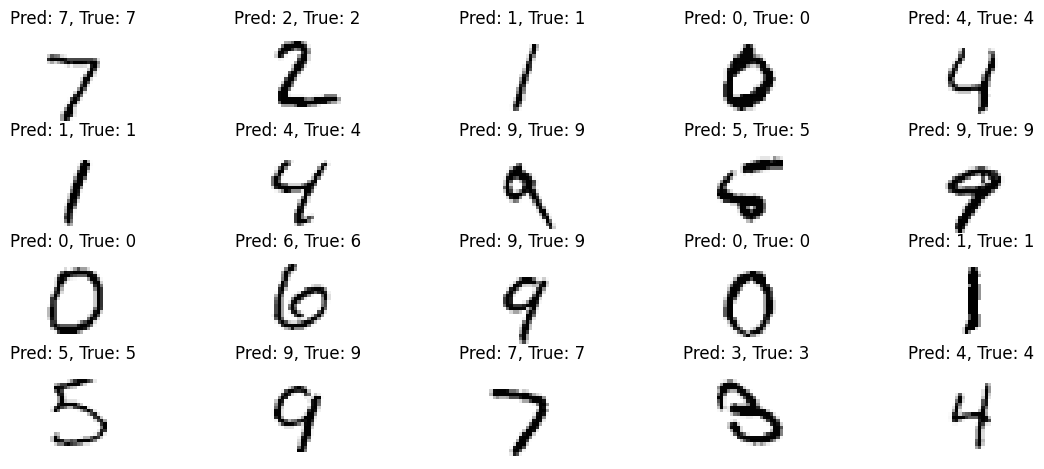

In [26]:
# Let's plot a few digits together with their predictions
# Plot the first 20 digits with predicted and actual labels
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(predictions[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_test[idx]))
plt.show()

More informative are probably those digits that were not correctly predicted.  
Thus, plot the first 20 incorrectly predicted digits to understand why they were predicted incorrectly.

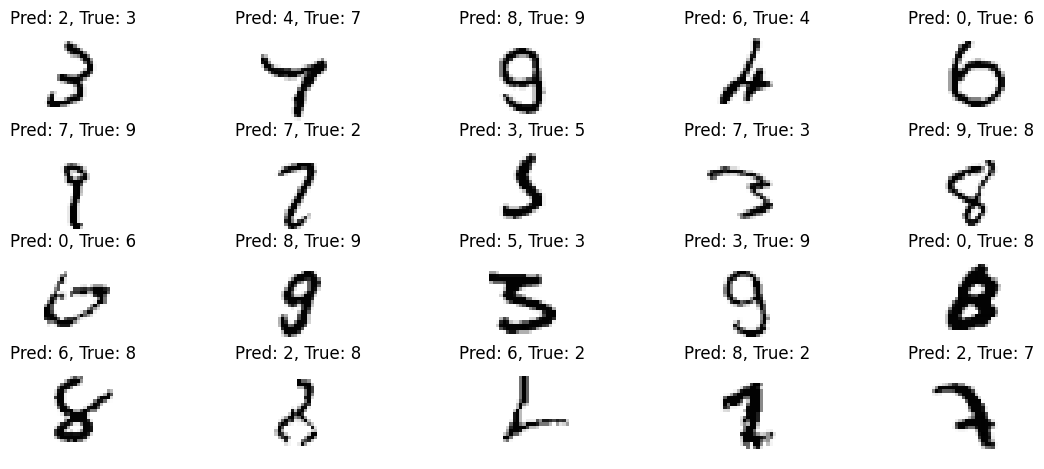

In [27]:
y_pred_incorrect = predictions[predictions != y_test]
y_actual_incorrect = y_test[predictions != y_test]
X_test_incorrect = X_test[predictions != y_test]
plt.figure(figsize=(14, 7))
for idx, prediction in enumerate(y_pred_incorrect[:20]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(X_test_incorrect[idx].reshape(28, 28), cmap=plt.cm.Greys, interpolation="none")
    plt.axis("off")
    plt.title("Pred: {}, True: {}".format(prediction, y_actual_incorrect[idx]))
plt.show()

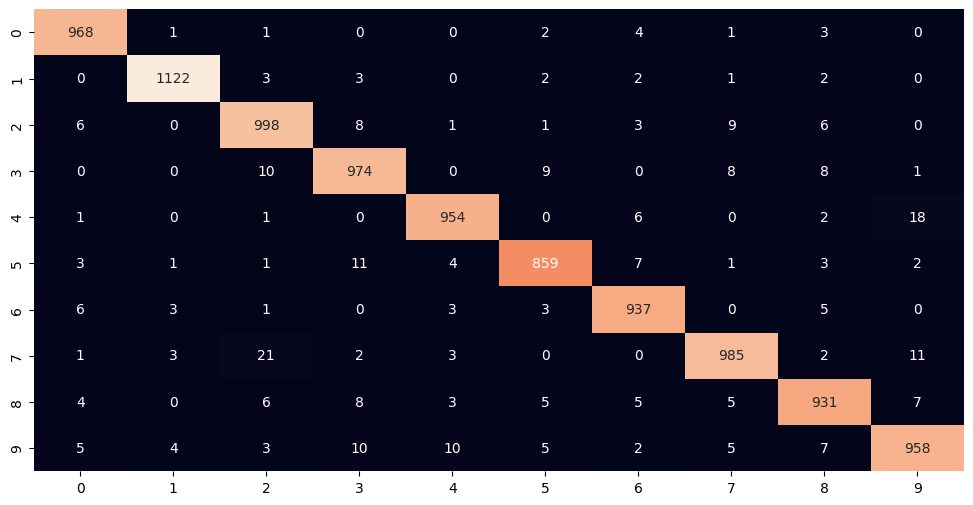

In [28]:
# Plot the confusion matrix of our predictions
_fig, ax5 = plt.subplots(figsize=(12, 6))
sns.heatmap(metrics.confusion_matrix(y_test, predictions), cbar=False, annot=True, fmt="", ax=ax5)
plt.show()

We see the performance of a random forest classifier is fairly comparable to our ANN (model 1) and our CNN (model 2). So the question remains whether using an ANN/CNN with its higher computational costs is really necessary for MNIST digits dataset.